In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

In [2]:
data_path = "/home/henrique/Documents/Atmos_Pandora/data/ereco2/"
anatree = Anatree(f'{data_path}/original.root', load_data=False)
anatree_new = Anatree(f'{data_path}/modifications_chi2_llhd_minimal.root', load_data=False)
anatree.tree:uproot.TTree

In [3]:
nu: pl.DataFrame
reco_tracks:pl.DataFrame
nu_new:pl.DataFrame
reco_tracks_new:pl.DataFrame

anatree.read_parquet(f"../data/parquet_anatree_production/")
nu = anatree.nu.collect()
reco_tracks = anatree.reco_tracks.collect()



Reading nu files... 57/57

Reading reco_tracks files... 57/57

Reading pfp files... 57/57


In [9]:
def select_numu_cc(df:pl.DataFrame):
    df = df.filter(
        (pl.col('ccnc_truth')==1)
    ).with_columns(
        E = pl.col('enu_truth'),
        Enc = pl.col('Ev_reco_nc')
    )
    return df
dfnu = select_numu_cc(nu)
dfnu

run,subrun,event,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,lep_mom_truth,lep_dcosx_truth,lep_dcosy_truth,lep_dcosz_truth,mode_truth,nuWeight_truth,Q2_truth,W_truth,X_truth,Y_truth,pot,Ev_reco_nue,RecoLepEnNue,RecoHadEnNue,RecoMethodNue,Ev_reco_numu,RecoLepEnNumu,RecoHadEnNumu,RecoMethodNumu,LongestTrackContNumu,TrackMomMethodNumu,RecoLepEnNumu_range,RecoLepEnNumu_mcs_chi2,RecoLepEnNumu_mcs_llhd,Ev_reco_nc,nuvtxx,nuvtxy,nuvtxz,E,Enc
i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f64,f32,f32,f32,i16,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f64,f64,f64,f32,f32
1497,1,44404,14,1,81.406601,473.128265,244.508255,0.270771,0.083108,-0.797165,0.598018,0.073238,0.574201,-0.052181,-0.81705,10,3.4690244e7,0.055499,1.094077,0.149619,0.729519,-99999.0,0.073532,0.022964,0.050568,2,0.174023,0.123455,0.050568,1,1,1,0.123455,0.0,0.0,0.080829,52.161163,442.03775,281.73288,0.270771,0.080829
1497,1,44408,12,1,-136.088074,210.644516,1259.389771,0.222674,-0.638082,-0.531017,0.557567,0.133142,0.85613,-0.003678,-0.516747,0,3.1405376e7,0.108655,0.970072,0.646267,0.402077,-99999.0,0.037621,0.034695,0.002925,2,0.134693,0.131767,0.002925,1,1,1,0.131767,0.0,0.0,0.037837,-136.709396,211.09024,1259.438477,0.222674,0.037837
1497,1,44409,12,1,-41.059158,-316.750122,776.458008,0.61177,0.226379,-0.190209,-0.955293,0.500454,0.096948,0.152605,-0.983521,0,5.6215876e7,0.041354,1.024328,0.197836,0.181957,-99999.0,0.028969,0.022667,0.006302,2,0.131984,0.125682,0.006302,1,1,1,0.125682,0.0,0.0,0.029542,-40.415432,-317.298065,776.585266,0.61177,0.029542
1497,1,44414,16,1,-142.140839,-424.572662,121.005325,0.192481,-0.144553,0.984977,-0.094472,0.107716,0.984424,0.126128,0.122479,0,2.1007698e7,0.042696,0.999023,0.268234,0.440378,-99999.0,0.023349,0.018585,0.004764,2,0.122472,0.117708,0.004764,1,1,1,0.117708,0.0,0.0,0.023928,-142.034683,-424.538055,120.726097,0.192481,0.023928
1497,1,44415,14,1,21.238211,474.986084,776.272888,0.451579,0.209437,-0.934854,-0.286681,0.131972,0.533509,-0.444273,-0.719715,1,4.3569572e7,0.031777,1.204144,0.052947,0.707754,-99999.0,0.156229,0.085577,0.070652,2,0.248171,0.177518,0.070652,1,1,1,0.177518,0.0,0.0,0.166967,21.573893,475.394867,776.106873,0.451579,0.166967
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1500,1,19065,16,1,-203.705933,159.211487,1354.05249,0.371794,-0.084442,-0.696783,0.712299,0.242962,0.473411,0.818709,-0.324959,0,4.2063056e7,0.332767,0.889228,1.375501,0.346512,-99999.0,0.048639,0.031086,0.017553,2,0.141495,0.123942,0.017553,1,1,1,0.123942,0.0,0.0,0.048142,-203.936813,158.271484,1354.532715,0.371794,0.048142
1500,1,19066,-12,1,-116.004951,-407.837616,261.474274,10.073218,-0.195792,0.213921,0.957034,10.011888,-0.221341,0.236612,0.946057,0,3.8019904e7,0.129914,0.931034,1.128023,0.006089,-99999.0,0.022258,0.000511,0.021747,2,0.144436,0.122688,0.021747,1,1,1,0.122688,0.0,0.0,0.022657,-115.644875,-408.546417,261.251862,10.073218,0.022657
1500,1,19069,-16,1,-183.566208,559.82489,769.740845,0.898274,0.509874,0.631839,0.583794,0.665678,0.140637,0.358741,0.922782,0,4.071466e7,0.194836,1.059957,0.446076,0.258936,-99999.0,0.131365,0.128211,0.003154,2,0.189353,0.186199,0.003154,1,1,1,0.186199,0.0,0.583604,0.138647,-183.39772,559.427856,769.324707,0.898274,0.138647


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


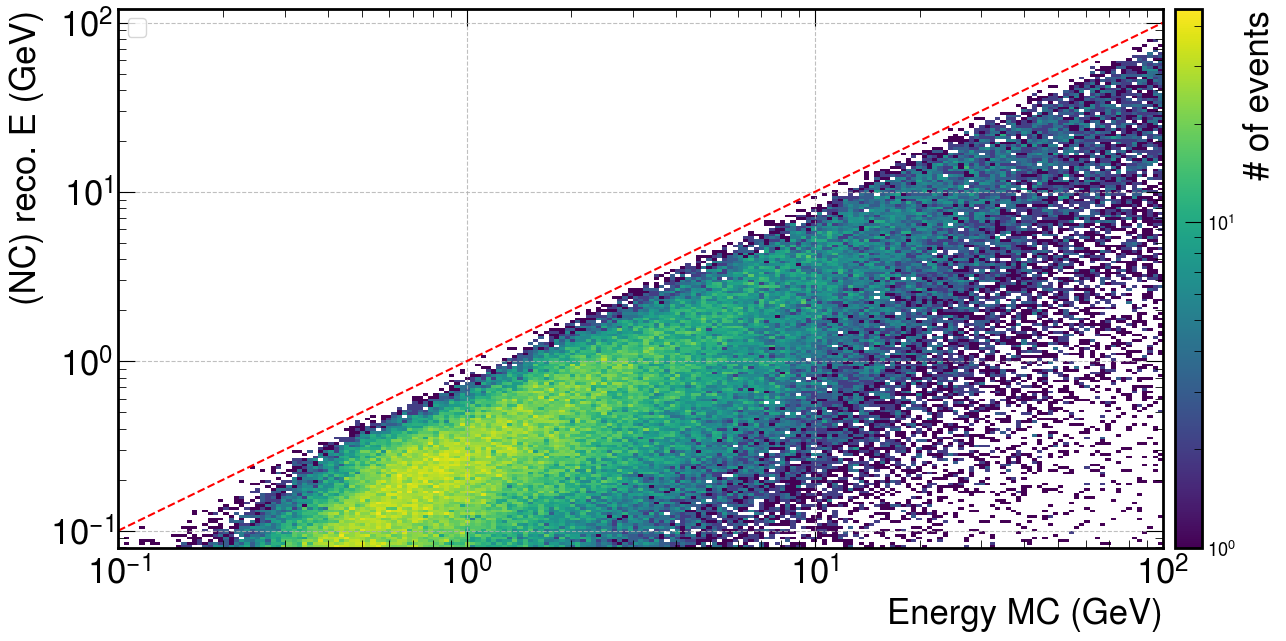

In [12]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_mu_vs_mu(Emu:pl.DataFrame, label, lmethod, x='E', y='RecoLepEnNumu'):

    fig = plt.figure(figsize=(14,6.7))
    binsx = np.logspace(-1,2,200)
    binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=25
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=LogNorm());
    plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Energy MC (GeV)', fontsize=fontsize)
    plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    legend = plt.legend(frameon=True, title=lmethod, loc='upper left')
    plt.setp(legend.get_title(),fontsize='x-large')

# plot_mu_vs_mu(Emu.filter(pl.col('rec.LongestTrackContNumu')==1), label='(old)')
plot_mu_vs_mu(dfnu,  y='Enc', label='(NC)', lmethod='')

In [14]:

from scipy.stats import binned_statistic
import matplotlib.ticker as ticker
def display_2d(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    legendtitle='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    zscale='log',
                    figsize=(10,4.2),
                    loc='upper right'):
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale, rasterized=True);
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale, rasterized=True);
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, )
    plt.ylabel(ylabel, )
    cbformat = ticker.ScalarFormatter()
    cbformat.set_axis(plt.gca())
    cbformat.set_scientific(True)
    cbformat.set_powerlimits((1,0))
    cbformat.set_useMathText(True)
    cbar = plt.colorbar(pad=0.01, format=cbformat)
    cbar.ax.set_ylabel('# of events')
    if legendtitle:
        legend = plt.legend(frameon=True, title=legendtitle, loc=loc)
    plt.plot();

def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'True Muon Momentum [GeV/c]',
                    ylabel = '',
                    makefrac = True,
                    fmt='+',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    dunepos=None,
                    # fo='a.txt',
                    **kwargs):
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1)
    else:
        ploty = y
    print_data=False
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 1**2)
        if ylabel == '':
            ylabel = r'Muon candidate resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
        print_data = True
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$p_{reco}/p_{true}-1$'
        if title=='':
            title = 'Median'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    # if print_data:
    #     with open(fo,'w') as f:
    #         f.write(f'# E [GeV], Res [%]\n')
    #         for b, r in zip(bins_center, val):
    #             if not np.isnan(r):
    #                 f.write(f'{b:.3f}, {r:.3f}\n')
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, fontsize='x-large', title_fontsize='x-large')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)


def plot_res(xreco,
            xtrue,
            binsx = np.linspace(-1,2,200),
            xlabel = r'$\frac{p_{reco}}{p_{true}}-1$',
            ylabel = r'# of events',
            xscale='linear',
            yscale='linear',
            loc='best',
            title='',
            **kwargs):

    val = xtrue/xreco - 1;
    hh, he, _ = plt.hist(val, bins=binsx, histtype='step', **kwargs)
    plt.ylabel(ylabel, )
    plt.xlabel(xlabel, )
    plt.xscale(xscale)
    plt.yscale(yscale)
    legend = plt.legend(title=title, loc=loc, fontsize='xx-large')
    plt.xlim(binsx[0],binsx[-1])
    return hh, he
    

(-1.0, 0.0)

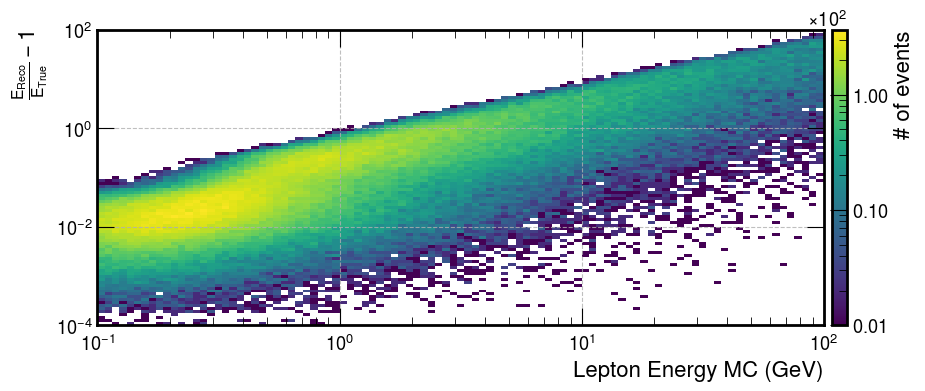

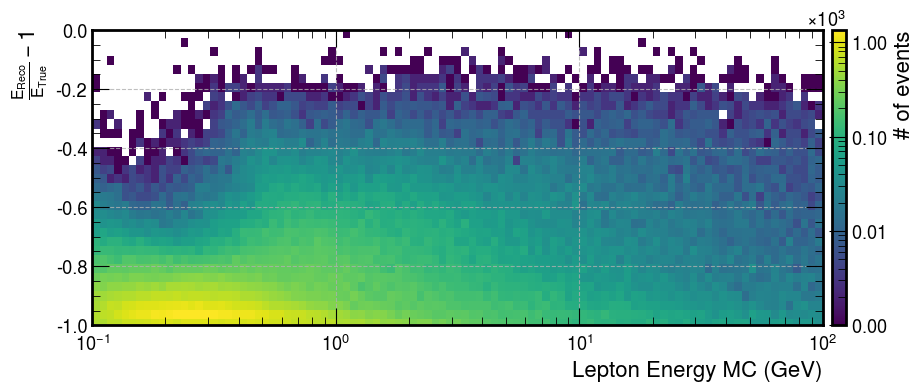

In [62]:
binse = np.logspace(-1,2,100)
binsy = np.logspace(-4,2,100)
display_2d(dfnu['E'], dfnu['Enc'], makefrac=False, binsx=binse, binsy=binsy)
plt.yscale('log')

display_2d(dfnu['E'], dfnu['Enc'], binsx=binse)
plt.ylim(-1,0)
# plt.yscale('log')

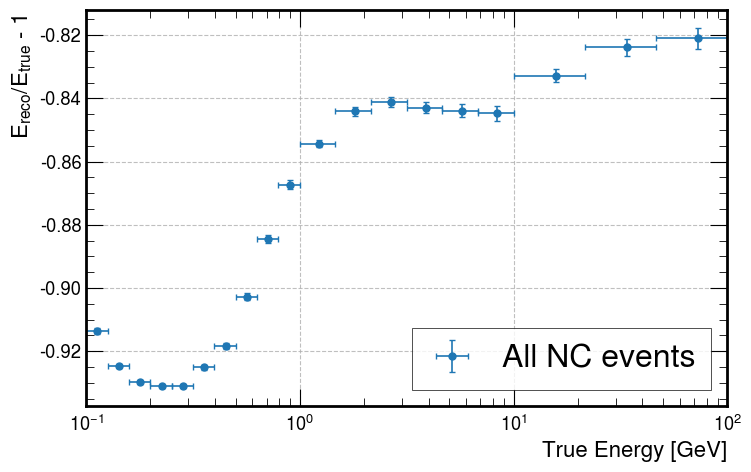

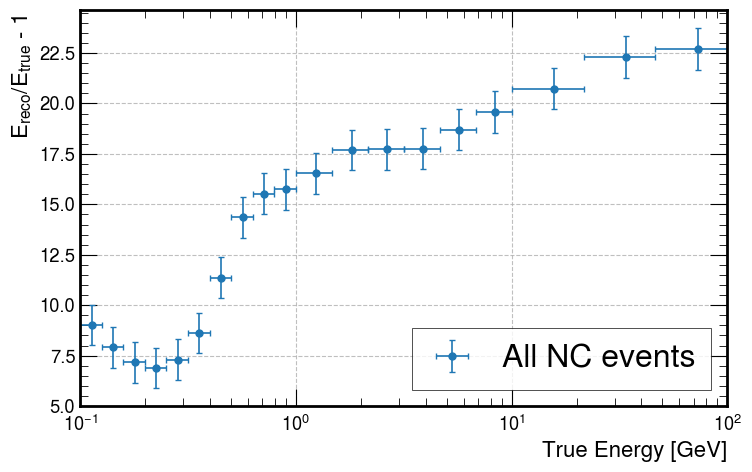

In [73]:
binsx = np.logspace(-1,0,10, endpoint=False)
binsx = np.append(binsx,np.logspace(0,1,6, endpoint=False))
binsx = np.append(binsx,np.logspace(1,2,4, endpoint=True))
plt.figure(figsize=(7.8,5))
plot_res_scatter(dfnu['E'],
                 dfnu['Enc'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 infotype='median',
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'All NC events',
                 ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                 xlabel='True Energy [GeV]',
                 loc='lower right',
                 dunepos=None,
                #  leg_ancor=(0.,0.65,0.99,0.4),
                )
plt.figure(figsize=(7.8,5))
plot_res_scatter(dfnu['E'],
                 dfnu['Enc'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 infotype='std',
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'All NC events',
                 ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                 xlabel='True Energy [GeV]',
                 dunepos=None,
                 loc='lower right',
                #  leg_ancor=(0.,0.65,0.99,0.4),
                )